# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **FakeNewsNet** by using pretrained **BERT** Embeddings, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [ ]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract   
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter
import nltk 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

In [2]:
pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

***
## 2. Dataset Cleaning and Preprocessing

From the downloaded Fakenewsnet dataset, assign four variables with corresponding paths urls for the two class-labelled variables that should be in the common **input_dataset** folder as created for the whole experiment.

In [3]:
foldr_pol_real = 'input_dataset//fakenewsnet//politifact//real//'
foldr_pol_fake = 'input_dataset//fakenewsnet//politifact//fake//'
foldr_gos_real = 'input_dataset//fakenewsnet//gossipcop//real//'
foldr_gos_fake = 'input_dataset//fakenewsnet//gossipcop//fake//'

*** 

### Function to extract or convert  attributes from JSON  News Content format to  dataframe

This script is using to extract multiple attributes of the news content from the JSON file  and filtered the domain names from the url attribute  and created a new dataframe.


In [4]:
def json_to_newscontent(datapath):
    dictlist = []
    cols = ['url','text','title','authors','num_images','domain']
    folders = glob.glob(datapath+'/*')
    for index, subdir in enumerate(folders):
        path_file = glob.glob(subdir+'/*')
        #check whether file path is valid or not
        if len(path_file) == 1:
            file = open(path_file[0]).read()
            jsondata = json.loads(file)
            thedict = {'url':jsondata['url'],'title':jsondata['title'],'text':jsondata['text'],
                   'num_images':len(jsondata['images']),'authors':str(jsondata['authors'])}
            extrt_url = tldextract.extract(jsondata['url'])
            thedict['domain'] = extrt_url.domain
            dictlist.append(thedict)
    df=pd.DataFrame(dictlist,columns=cols)
    return df

##### Converting seperate dataframes for Politfact fake and real and Gossip fake and real

In [5]:
import time

# get the start time
st = time.time()

df_pol_real = json_to_newscontent(foldr_pol_real)
df_pol_fake = json_to_newscontent(foldr_pol_fake)
df_gos_real = json_to_newscontent(foldr_gos_real)
df_gos_fake = json_to_newscontent(foldr_gos_fake)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 312.7435884475708 seconds


##### Removing rows having  missing value in the column named 'TEXT'

In [6]:
## Cleaned dataset
df_pol_real = df_pol_real.loc[df_pol_real["text"] != '' ]
df_pol_fake = df_pol_fake.loc[df_pol_fake["text"] != '' ]
df_gos_real = df_gos_real.loc[df_gos_real["text"] != '' ]
df_gos_fake = df_gos_fake.loc[df_gos_fake["text"] != '' ]

df_pol_real.reset_index(drop=True,inplace=True)
df_pol_fake.reset_index(drop=True,inplace=True)
df_gos_real.reset_index(drop=True,inplace=True)
df_gos_fake.reset_index(drop=True,inplace=True)

Created one new column named **Category** to identify whether a news article belongs to Politics or Gossip related

In [7]:
df_pol_real['Category'] = 'Politics' 
df_pol_fake['Category'] = 'Politics'
df_gos_real['Category'] = 'Gossips'
df_gos_fake['Category'] = 'Gossips'

##### Add response variable 'class' based on True=1 or Fake=0

In [8]:
df_pol_real['class'] = 0 #True
df_pol_fake['class'] = 1 #Fake
df_gos_real['class'] = 0
df_gos_fake['class'] = 1

##### Merging all the four dataframes into a single dataframe for the further steps

In [14]:
df_list = [df_pol_real,df_pol_fake,df_gos_real,df_gos_fake]

In [15]:
#combine df's into one
df = pd.concat(df_list).reset_index(drop=True)
total_rows = df.shape[0]

#####  Next step is to create a new column named  'fulltext'  with the combination of 'title' and 'text' columns

In [17]:
df['fulltext']=df['title']+'.'+df['text']
df=df.dropna()
df.shape

(20362, 9)

#### Saving Fulldataset to csv format in  a location

In [3]:
df.to_csv('Updated//full_dataset.csv', index=False)

#### Create a new dataframe by considering two columns 'fulltext' and 'class'

In [5]:
filterd_df=df[['fulltext','class']]

***

## 3. Model Training and Evaluation

### BERT Embeddings

Next step is extract features from the news text column using pretrained BERT embeddings model

###### Create a pandas series dataframe which consists only fulltext column values

In [7]:
texts=filterd_df['fulltext']

##### Download the Pretrained BERT embedding preprocessor and encoder  model from tensorflow hub

In [ ]:
# bert preprocessor - https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# bert encoder - https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2",trainable=True)

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.
Since our dataset is huge and it is not possible to transform full data to numeric token ids , we can do the same by splitting the data into multiple chunks as like below

**First set** =  Create a first chunk of text series dataframe with first 10000 rows

In [9]:
# preprocessing dataset  - First Set
inputs = preprocessor(texts[0:10000])

After executing the above command, 3 outputs from the preprocessing will be generated that a BERT model would use (input_words_id, input_mask and input_type_ids).
Then encode the output and convert it into bert model features which can be feed to the model

In [ ]:
# feeding it to model for vectorization
outputs = encoder(inputs)

The above output BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. 
- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. 
- encoder_outputs are the intermediate activations of the L Transformer block


In [12]:
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].

Then convert bert encoder sequence outputs to 1 dimension  and save the encoder sequence output to a dataframe for a single chunk.This same process need to do for all the splitted data chunks and then need to merge all the dataframes into a single one , which will feed to the model training

In [16]:
# defining dataframe
bertf_df1=pd.DataFrame()

## Converting bert encoder sequence output to 1 dimension for ML Model training
for i in range(0,len(sequence_output)):
    b=sequence_output[i].numpy().sum(axis=0)
    bertf_df1=bertf_df1.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


**Second set** =  Create a next chunk of text series dataframe ranging from 10000 to 21000

In [19]:
# preprocessing dataset  - Second Set
inputs2 = preprocessor(texts[10000:21000])
# feeding it to model for vectorization
outputs2 = encoder(inputs2)

In [20]:
pooled_output2 = outputs2["pooled_output"]      # [batch_size, 512].
sequence_output2 = outputs2["sequence_output"]  # [batch_size, seq_length, 512].

In [21]:
bertf_df2=pd.DataFrame()

In [22]:
for i in range(0,len(sequence_output2)):
    b=sequence_output2[i].numpy().sum(axis=0)
    bertf_df2=bertf_df2.append(pd.Series(b),ignore_index=True)
print('values added in dataframe')

values added in dataframe


Merge all the bert feature dataframes into a single one , which will feed to the model training

In [27]:
# merging both props 
bertVectors_fulldf=pd.concat([bertf_df1,bertf_df2])
bertVectors_fulldf.reset_index(drop=True,inplace=True)

Then add class label column in the merged bert feature dataframe and then this dataframe will go with train-test data splitting

In [28]:
# adding class labels
bertVectors_fulldf.insert(len(bertVectors_fulldf.columns),'class',filterd_df['class'])

#### Convert Bertvectors dataframe  to CSV format  and store in a path

In [ ]:
bertVectors_fulldf.to_csv('Updated//bertVectors_fulldf.csv', index=False)

#### Splitting bert vectors dataframe into features and class 

In [18]:
X=bertVectors_fulldf.drop('class',axis=1)
y=bertVectors_fulldf['class']

#### Using StratifiedKFold technique to create X_train , X_test, Y_train and Y_test

In [19]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [20]:
for i, j in kfold.split(X, y):
    # select rows
    X_train, X_test = X.iloc[i], X.iloc[j]
    y_train, y_test = y.iloc[i], y.iloc[j]

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [22]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [23]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***

## Random Forest

**Initialise Random Forest model and  fit using train data**

In [24]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf_model = rf.fit(X_train, y_train)

**Use the trained model to make predictions on the test data**

In [25]:
y_pred = rf_model.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, y_pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, y_pred)))
print("Classification Report")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, y_pred)
print("Recall : {}".format(recall))

Accuracy score : 0.8202357563850687
Confusion matrix : 
 [[3000   62]
 [ 670  340]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3062
           1       0.85      0.34      0.48      1010

    accuracy                           0.82      4072
   macro avg       0.83      0.66      0.69      4072
weighted avg       0.82      0.82      0.79      4072

Precision : 0.845771144278607
Recall : 0.33663366336633666


### Hyperparameter Tuning for Random Forest

Define the list of parameters which needed to do hyperparameter tuning


In [9]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(10, 110, num = 11)]
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)



{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [10]:
rf_clf1=RandomForestClassifier(random_state=0)

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

#### Train Random Forest using with Best Params 

In [26]:
rf_clf_tuned=RandomForestClassifier(random_state=0,n_estimators=600,max_features='auto',max_depth=70,min_samples_split=2,min_samples_leaf=2,bootstrap=False)

rf_clf_tuned.fit(X_train, y_train)

import pickle
# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_RF_bert.sav'
pickle.dump(rf_clf_tuned, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [27]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_RF_bert.sav'

rf_clf_tuned = pickle.load(open(filename, 'rb'))

pred = rf_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8241650294695482
Confusion matrix : 
 [[3008   54]
 [ 662  348]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      3062
           1       0.87      0.34      0.49      1010

    accuracy                           0.82      4072
   macro avg       0.84      0.66      0.69      4072
weighted avg       0.83      0.82      0.79      4072

Precision : 0.8656716417910447
Recall : 0.3445544554455445
F1 Score : 0.49291784702549574


**Save the classification report to csv**

In [29]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_RF_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.819619,0.982364,0.893642,3062.000000
1,0.865672,0.344554,0.492918,1010.000000
accuracy,0.824165,0.824165,0.824165,0.824165
macro avg,0.842645,0.663459,0.693280,4072.000000
weighted avg,0.831041,0.824165,0.794248,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

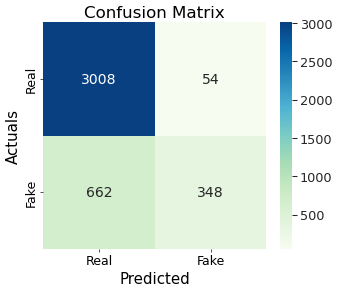

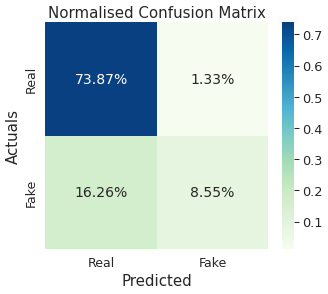

In [30]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_RF_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_RF_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

*** 
### Support Vector Machine

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [31]:
svm_clf=SVC(random_state=0)

In [32]:
svm_clf.fit(X_train, y_train)

pred = svm_clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8266208251473477
Confusion matrix : 
 [[2967   95]
 [ 611  399]]
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      3062
           1       0.81      0.40      0.53      1010

    accuracy                           0.83      4072
   macro avg       0.82      0.68      0.71      4072
weighted avg       0.82      0.83      0.80      4072



#### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [21]:
# Create the random grid
random_grid = {
    'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel':  ['rbf', 'poly', 'sigmoid'],
              }
pprint(random_grid)


{'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf', 'poly', 'sigmoid']}


**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [23]:

svm_clf1=SVC(random_state=0)

rf_random = RandomizedSearchCV(estimator=svm_clf1, param_distributions=random_grid,
                              n_iter = 50, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time= 1.1min
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time= 1.1min
[CV] END .....................C=1000, gamma=0.01, kernel=rbf; total time= 5.3min
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=  41.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.4min
[CV] END ..................C=1000, gamma=0.0001, kernel=poly; total time= 1.7min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 5.9min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=  55.1s
[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=  44.5s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=  43.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 3.4min
[CV] END ..................C=1000, gamma=0.0001

KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

### Using with Best Params 


**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [33]:
svm_clf_tuned=SVC(random_state=0,probability=True)

svm_clf_tuned.fit(X_train, y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_SVM_bert.sav'
pickle.dump(svm_clf_tuned, open(filename, 'wb'))
print('SVM - Completed')

SVM - Completed


In [36]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_SVM_bert.sav'

svm_clf_tuned = pickle.load(open(filename, 'rb'))

#pred = svm_clf_tuned.predict(X_test)

y_pred = svm_clf_tuned.predict_proba(X_test)[:, 1]
pred=np.array((y_pred > 0.3).astype(int))

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.805992141453831
Confusion matrix : 
 [[2637  425]
 [ 365  645]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3062
           1       0.60      0.64      0.62      1010

    accuracy                           0.81      4072
   macro avg       0.74      0.75      0.74      4072
weighted avg       0.81      0.81      0.81      4072

Precision : 0.602803738317757
Recall : 0.6386138613861386
F1 Score : 0.6201923076923077


**Save the classification report to csv**

In [38]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_SVM_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.878414,0.861202,0.869723,3062.000000
1,0.602804,0.638614,0.620192,1010.000000
accuracy,0.805992,0.805992,0.805992,0.805992
macro avg,0.740609,0.749908,0.744958,4072.000000
weighted avg,0.810053,0.805992,0.807831,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

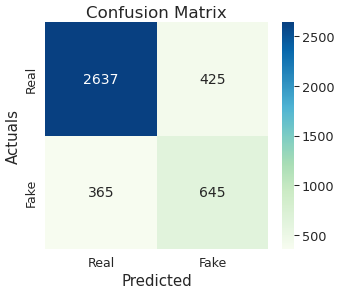

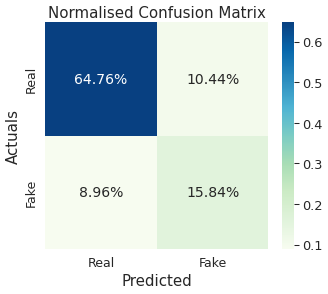

In [39]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_SVM_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_SVM_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [40]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [41]:
knn_clf.fit(X_train,y_train)

pred = knn_clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.81213163064833
Confusion matrix : 
 [[2794  268]
 [ 497  513]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3062
           1       0.66      0.51      0.57      1010

    accuracy                           0.81      4072
   macro avg       0.75      0.71      0.73      4072
weighted avg       0.80      0.81      0.80      4072



#### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [30]:
# Create the random grid
random_grid = {
    'leaf_size': list(range(1,50)),
               'n_neighbors': list(range(1,30)),
               'p':  [1,2],
              }
pprint(random_grid)

{'leaf_size': [1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49],
 'n_neighbors': [1,
                 2,
                 3,
                 

**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [31]:

knn_clf1=KNeighborsClassifier()

rf_random = RandomizedSearchCV(estimator=knn_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................leaf_size=17, n_neighbors=19, p=2; total time=   4.9s
[CV] END ..................leaf_size=14, n_neighbors=29, p=2; total time=   3.4s
[CV] END ...................leaf_size=10, n_neighbors=6, p=2; total time=   3.6s
[CV] END ..................leaf_size=15, n_neighbors=15, p=2; total time=   3.1s
[CV] END ...................leaf_size=38, n_neighbors=8, p=2; total time=   3.4s
[CV] END ..................leaf_size=41, n_neighbors=27, p=2; total time=   3.0s
[CV] END ...................leaf_size=14, n_neighbors=6, p=2; total time=   3.3s
[CV] END ...................leaf_size=3, n_neighbors=13, p=2; total time=   3.0s
[CV] END ..................leaf_size=18, n_neighbors=16, p=2; total time=   3.0s
[CV] END ..................leaf_size=21, n_neighbors=24, p=1; total time= 2.1min
[CV] END ..................leaf_size=27, n_neighbors=16, p=1; total time= 2.3min


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, return_train_score=True, verbose=2

In [33]:
rf_random.best_params_

{'p': 1, 'n_neighbors': 27, 'leaf_size': 13}

### Using with Best Params 


**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [42]:
knn_clf_tuned=KNeighborsClassifier(n_neighbors=27,leaf_size=13,p=1)
knn_clf_tuned.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_KNN_bert.sav'
pickle.dump(svm_clf_tuned, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


In [51]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_KNN_bert.sav'

knn_clf_tuned = pickle.load(open(filename, 'rb'))

#pred = knn_clf_tuned.predict(X_test)
y_pred = knn_clf_tuned.predict_proba(X_test)[:, 1]
pred=np.array((y_pred > 0.4).astype(int))

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8295677799607073
Confusion matrix : 
 [[2825  237]
 [ 457  553]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3062
           1       0.70      0.55      0.61      1010

    accuracy                           0.83      4072
   macro avg       0.78      0.74      0.75      4072
weighted avg       0.82      0.83      0.82      4072

Precision : 0.7
Recall : 0.5475247524752476
F1 Score : 0.6144444444444445


**Save the classification report to csv**

In [52]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_KNN_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.860756,0.922600,0.890605,3062.000000
1,0.700000,0.547525,0.614444,1010.000000
accuracy,0.829568,0.829568,0.829568,0.829568
macro avg,0.780378,0.735062,0.752525,4072.000000
weighted avg,0.820883,0.829568,0.822108,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

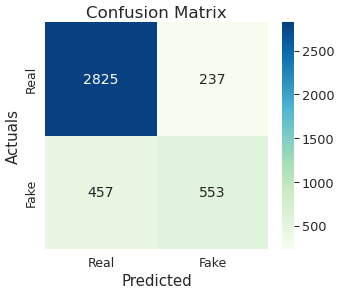

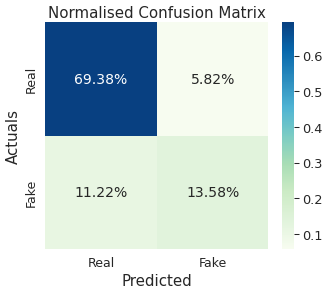

In [53]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_KNN_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_KNN_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [54]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train,y_train)

pred = xg_clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))


Accuracy score : 0.8295677799607073
Confusion matrix : 
 [[2889  173]
 [ 521  489]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3062
           1       0.74      0.48      0.58      1010

    accuracy                           0.83      4072
   macro avg       0.79      0.71      0.74      4072
weighted avg       0.82      0.83      0.82      4072



#### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [36]:
# Create the random grid
random_grid = {
    'min_child_weight': range(1,6,2),
    'gamma': list(range(1,30)),
    'max_depth':  range(3,15,2),
    'alpha': [1e-5, 1e-2, 0.1,1,10,50, 100],
    'subsample':np.arange(0.5, 1.0, 0.1),
    'scale_pos_weight':range(1,5,1),
    'colsample_bytree':np.arange(0.5, 1.0, 0.1),
    'n_estimators':[100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    }
pprint(random_grid)

{'alpha': [1e-05, 0.01, 0.1, 1, 10, 50, 100],
 'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'gamma': [1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19,
           20,
           21,
           22,
           23,
           24,
           25,
           26,
           27,
           28,
           29],
 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
 'max_depth': range(3, 15, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 250, 500],
 'scale_pos_weight': range(1, 5),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}


**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [37]:

xg_clf1=XGBClassifier(random_state=0)


rf_random = RandomizedSearchCV(estimator=xg_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END alpha=50, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=19, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100, scale_pos_weight=2, subsample=0.7999999999999999; total time=  48.8s
[CV] END alpha=0.01, colsample_bylevel=0.5, colsample_bytree=0.7999999999999999, gamma=26, learning_rate=0.1, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=0.7999999999999999; total time=  53.2s
[CV] END alpha=0.1, colsample_bylevel=0.7, colsample_bytree=0.6, gamma=27, learning_rate=0.2, max_depth=11, min_child_weight=3, n_estimators=250, scale_pos_weight=4, subsample=0.8999999999999999; total time= 3.6min
[CV] END alpha=50, colsample_bylevel=0.5, colsample_bytree=0.7999999999999999, gamma=22, learning_rate=0.4, max_depth=5, min_child_weight=5, n_estimators=500, scale_pos_weight=4, subsample=0.5; total time= 2.4min
[CV] END alpha=100, colsample_bylevel=0.8999999999

[CV] END alpha=100, colsample_bylevel=0.8999999999999999, colsample_bytree=0.6, gamma=15, learning_rate=0.4, max_depth=3, min_child_weight=1, n_estimators=500, scale_pos_weight=2, subsample=0.7; total time= 2.3min
[CV] END alpha=0.01, colsample_bylevel=0.7, colsample_bytree=0.8999999999999999, gamma=2, learning_rate=0.01, max_depth=13, min_child_weight=3, n_estimators=250, scale_pos_weight=3, subsample=0.5; total time= 4.0min
[CV] END alpha=0.1, colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, gamma=22, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=500, scale_pos_weight=2, subsample=0.6; total time= 5.4min
[CV] END alpha=100, colsample_bylevel=0.7999999999999999, colsample_bytree=0.8999999999999999, gamma=3, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=500, scale_pos_weight=1, subsample=0.5; total time= 1.6min
[CV] END alpha=50, colsample_bylevel=0.8999999999999999, colsample_bytree=0.7999999999999999, gamma=28, learning_rate=0.4, max_d

[CV] END alpha=50, colsample_bylevel=0.7, colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=500, scale_pos_weight=2, subsample=0.5; total time= 1.5min
[CV] END alpha=0.1, colsample_bylevel=0.7, colsample_bytree=0.7, gamma=14, learning_rate=0.4, max_depth=13, min_child_weight=1, n_estimators=100, scale_pos_weight=3, subsample=0.7999999999999999; total time= 1.8min
[CV] END alpha=1, colsample_bylevel=0.6, colsample_bytree=0.5, gamma=23, learning_rate=0.1, max_depth=11, min_child_weight=1, n_estimators=250, scale_pos_weight=4, subsample=0.7; total time= 2.5min
[CV] END alpha=1e-05, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=11, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=0.8999999999999999; total time=  29.6s
[CV] END alpha=10, colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, gamma=20, learning_rate=0.1, max_depth=11, min_child_weight=3, n_

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gam

In [39]:
rf_random.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 2,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 3,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.8999999999999999,
 'alpha': 1}

### Using with Best Params 


**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [55]:
xg_clf_tuned=XGBClassifier(subsample=0.7,scale_pos_weight=2,n_estimators=500,min_child_weight=3,max_depth=5,learning_rate=0.1,
                     gamma=3,colsample_bytree=0.79,colsample_bylevel=0.89,alpha=1)
xg_clf_tuned.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_XG_bert.sav'
pickle.dump(xg_clf_tuned, open(filename, 'wb'))
print('XgBoost - Completed')

XgBoost - Completed


In [56]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_XG_bert.sav'

xg_clf_tuned = pickle.load(open(filename, 'rb'))

pred = xg_clf_tuned.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8320235756385069
Confusion matrix : 
 [[2834  228]
 [ 456  554]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3062
           1       0.71      0.55      0.62      1010

    accuracy                           0.83      4072
   macro avg       0.78      0.74      0.76      4072
weighted avg       0.82      0.83      0.82      4072

Precision : 0.7084398976982097
Recall : 0.5485148514851486
F1 Score : 0.6183035714285714


**Save the classification report to csv**

In [59]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_XG_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.861398,0.925539,0.892317,3062.000000
1,0.708440,0.548515,0.618304,1010.000000
accuracy,0.832024,0.832024,0.832024,0.832024
macro avg,0.784919,0.737027,0.755310,4072.000000
weighted avg,0.823459,0.832024,0.824352,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

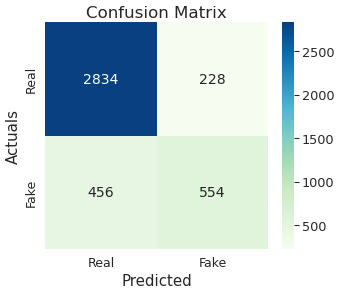

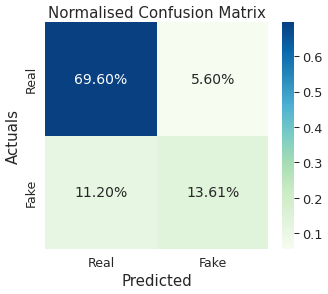

In [60]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_XG_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_XG_bert_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naiva Bayes

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
nb_clf=GaussianNB()
#p = Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
nb_clf.fit(X_train,y_train) 

pred = nb_clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.6863948919449901
Confusion matrix : 
 [[2102  960]
 [ 317  693]]
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3062
           1       0.42      0.69      0.52      1010

    accuracy                           0.69      4072
   macro avg       0.64      0.69      0.64      4072
weighted avg       0.76      0.69      0.71      4072



#### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [43]:
# Create the random grid
random_grid = {
    'var_smoothing': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
#    # 'class_prior':[True,False],
#     'fit_prior':[True,False]
              }
pprint(random_grid)

{'var_smoothing': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]}


**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [44]:

nb_clf1=GaussianNB()


rf_random = RandomizedSearchCV(estimator=nb_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': [1e-05, 0.0001, 0.001,
                                                          0.1, 1, 10, 100,
                                                          1000]},
                   random_state=42, return_train_score=True, verbose=2)

In [45]:
rf_random.best_params_

{'var_smoothing': 1}

### Using with Best Params 


**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [70]:
nb_clf_tuned=GaussianNB(var_smoothing=0.7)

nb_clf_tuned.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_NB_bert.sav'
pickle.dump(nb_clf_tuned, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


In [75]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_NB_bert.sav'

nb_clf_tuned = pickle.load(open(filename, 'rb'))

#pred = nb_clf_tuned.predict(X_test)

y_pred = nb_clf_tuned.predict_proba(X_test)[:, 1]
pred=np.array((y_pred > 0.35).astype(int))



print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.775294695481336
Confusion matrix : 
 [[2757  305]
 [ 610  400]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3062
           1       0.57      0.40      0.47      1010

    accuracy                           0.78      4072
   macro avg       0.69      0.65      0.66      4072
weighted avg       0.76      0.78      0.76      4072

Precision : 0.5673758865248227
Recall : 0.39603960396039606
F1 Score : 0.4664723032069971


**Save the classification report to csv**

In [78]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_NB_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.818830,0.900392,0.857676,3062.000000
1,0.567376,0.396040,0.466472,1010.000000
accuracy,0.775295,0.775295,0.775295,0.775295
macro avg,0.693103,0.648216,0.662074,4072.000000
weighted avg,0.756460,0.775295,0.760644,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

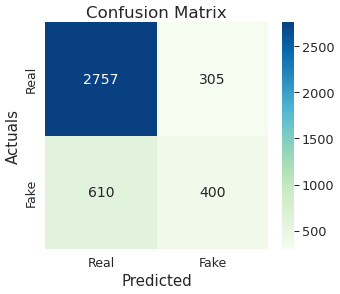

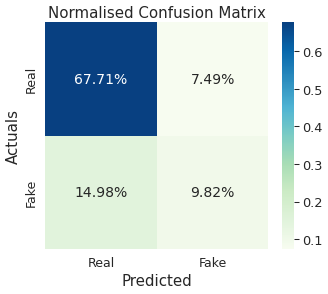

In [79]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_NB_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_NB_bert_cmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression

**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train,y_train)

pred = logticreg_clf.predict(X_test)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8172888015717092
Confusion matrix : 
 [[2846  216]
 [ 528  482]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3062
           1       0.69      0.48      0.56      1010

    accuracy                           0.82      4072
   macro avg       0.77      0.70      0.72      4072
weighted avg       0.81      0.82      0.81      4072



#### Hyperparameter Tuning 

Define the list of parameters which needed to do hyperparameter tuning

In [54]:
# Create the random grid
random_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'C':[100, 10, 1.0, 0.1, 0.01],
    'penalty':['l1','l2','elasticnet']
              }
pprint(random_grid)

{'C': [100, 10, 1.0, 0.1, 0.01],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


**Apply RandomizedSearchCV library for hyperparameter tuning  and fit the model using train data**

In [55]:

logticreg_clf_tuned=LogisticRegression()


rf_random = RandomizedSearchCV(estimator=logticreg_clf_tuned, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, return_train_score=True, verbose=2)

In [56]:
rf_random.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.01}

### Using with Best Params 


**Initialise the model and  fit it using train data and measure the accuracy metrics**

In [88]:
logticreg_clf_tuned=logticreg_clf=LogisticRegression()


logticreg_clf_tuned.fit(X_train,y_train)

# save the model to disk
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_LR_bert.sav'
pickle.dump(logticreg_clf_tuned, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


In [91]:
#Loading the model
filename = 'outputs//fakenewsnet_ml_bert//fakenewsnet_ml_LR_bert.sav'

logticreg_clf_tuned = pickle.load(open(filename, 'rb'))

#pred = logticreg_clf_tuned.predict(X_test)

y_pred = logticreg_clf_tuned.predict_proba(X_test)[:, 1]
pred=np.array((y_pred > 0.4).astype(int))



print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8084479371316307
Confusion matrix : 
 [[2727  335]
 [ 445  565]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3062
           1       0.63      0.56      0.59      1010

    accuracy                           0.81      4072
   macro avg       0.74      0.73      0.73      4072
weighted avg       0.80      0.81      0.80      4072

Precision : 0.6277777777777778
Recall : 0.5594059405940595
F1 Score : 0.5916230366492147


**Save the classification report to csv**

In [92]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_ml_bert//model_FAKENEWSNET_LR_BERT_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.859710,0.890594,0.874880,3062.000000
1,0.627778,0.559406,0.591623,1010.000000
accuracy,0.808448,0.808448,0.808448,0.808448
macro avg,0.743744,0.725000,0.733251,4072.000000
weighted avg,0.802183,0.808448,0.804622,4072.000000


**Plot confusion matrix using the user defined functions created earlier**

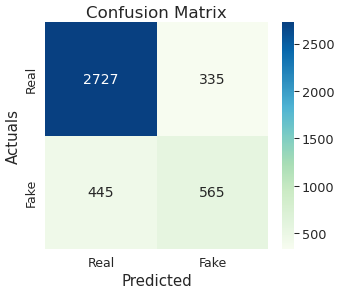

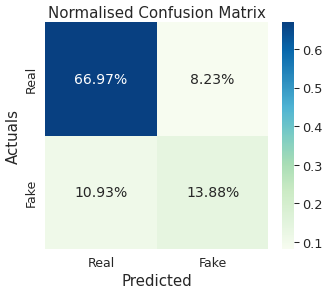

In [93]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_LR_bert_cmtrx.png"
path2="outputs//fakenewsnet_ml_bert//fakenewsnet_ml_LR_bert_cmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot based on the scores of all the algorithms

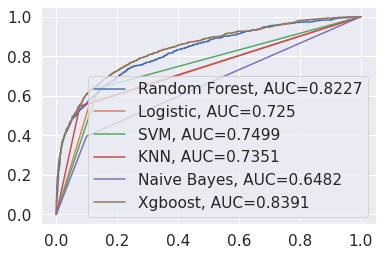

In [96]:
#set up plotting area
plt.figure(0).clf()

#fit RF model and plot ROC curve
y_pred = rf_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
y_pred = logticreg_clf_tuned.predict_proba(X_test)[:, 1]
y_pred=np.array((y_pred > 0.4).astype(int))
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
y_pred = svm_clf_tuned.predict_proba(X_test)[:, 1]
y_pred=np.array((y_pred > 0.3).astype(int))
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
y_pred = knn_clf_tuned.predict_proba(X_test)[:, 1]
y_pred=np.array((y_pred > 0.4).astype(int))
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
y_pred = nb_clf_tuned.predict_proba(X_test)[:, 1]
y_pred=np.array((y_pred > 0.35).astype(int))
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
y_pred = xg_clf_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()